### Digit Classifier
let's create a digit classifier to distinguis images between 3 and 7

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

We can see what’s in this directory by using `ls`, a method added by fastai. This method returns an object of a special fastai class called `L`, which has all the same functionality of Python’s built-in list, plus a lot more. One of its handy features is that, when printed, it displays the count of items before listing the items themselves (if there are more than 10 items, it shows just the first few):

In [3]:
path.ls()

(#3) [Path('C:/Users/vlad/.fastai/data/mnist_sample/labels.csv'),Path('C:/Users/vlad/.fastai/data/mnist_sample/train'),Path('C:/Users/vlad/.fastai/data/mnist_sample/valid')]

In [4]:
# Let’s see what’s inside the training set:
(path/'train').ls()

(#2) [Path('C:/Users/vlad/.fastai/data/mnist_sample/train/3'),Path('C:/Users/vlad/.fastai/data/mnist_sample/train/7')]

In [5]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [6]:
# Look at folde with 3s
threes

(#6131) [Path('C:/Users/vlad/.fastai/data/mnist_sample/train/3/10.png'),Path('C:/Users/vlad/.fastai/data/mnist_sample/train/3/10000.png'),Path('C:/Users/vlad/.fastai/data/mnist_sample/train/3/10011.png'),Path('C:/Users/vlad/.fastai/data/mnist_sample/train/3/10031.png'),Path('C:/Users/vlad/.fastai/data/mnist_sample/train/3/10034.png'),Path('C:/Users/vlad/.fastai/data/mnist_sample/train/3/10042.png'),Path('C:/Users/vlad/.fastai/data/mnist_sample/train/3/10052.png'),Path('C:/Users/vlad/.fastai/data/mnist_sample/train/3/1007.png'),Path('C:/Users/vlad/.fastai/data/mnist_sample/train/3/10074.png'),Path('C:/Users/vlad/.fastai/data/mnist_sample/train/3/10091.png')...]

In [12]:
# Look at the image 
img_3_path = threes[1]
img_3 = Image.open(img_3_path)
img_3

### Python Image Library - PIL 
It is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so **it displays the image for us automatically.**

In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a `NumPy array`  or a `PyTorch tensor`

In [13]:
# Part of the image using NumPy
array(img_3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [14]:
# Part of the image using PyTorch 
tensor(img_3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

### Image Visualisation using Pandas 
We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values

In [15]:
img_3_t = tensor(img_3)
df = pd.DataFrame(img_3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


- Learning works best when you try to solve problems yourself, rather than just reading somebody else’s answers

### Baseline Approach 
Baselien model is a model that you are confident should perform reasonably well. It should be simple to implement and easy to test, so that you can then test each of your improved ideas and make sure they are always better than your baseline. 

Without starting with a sensible baseline, it is difficult to know whether your super-fancy models are any good.

**Simple Baseline Solutions** 
1. Start with easy-to-implement model
2. Download a model for the problem and try to improve it

### Pixel Similarity

**Idea**

We can  find the average pixel value for every pixel of the 3s, then do the same for the 7s.

In [16]:
sevens = [tensor(Image.open(number)) for number in sevens]
threes = [tensor(Image.open(number)) for number in threes]
len(threes), len(sevens)

(6131, 6265)

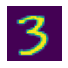

In [17]:
# look t at the image 
show_image(threes[1]);

For **every pixel position, we want to compute the average over all the images of the intensity of that pixel.** To do this, we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a rank-3 tensor.

**Important Note**

- Pixel values are `integres` but after calculating the average values we will need `float` data type.
- When images are `floats`, the pixel values are expected to be between 0 and 1, so we will also **divide by 255 here**

In [18]:
sevens = torch.stack(sevens).float()/255
threes = torch.stack(threes).float()/255
threes.shape

torch.Size([6131, 28, 28])

- The most important attribute of a tensor is its `shape`
- The length of a tensor’s shape is its `rank` - **rank is the number of axis or dimensions in a tensor**
- `Shape` - the size of each axis of a tensor

In [19]:
print('Tensor Rank: ', len(threes.shape))
print('Tensor Rank: ', threes.ndim)

Tensor Rank:  3
Tensor Rank:  3


Finally, we can compute what the ideal 3 looks like. We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. In other words, for every pixel position, this will compute the average of that pixel over all images. The result will be one value for every pixel position, or a single image.

Here it is:

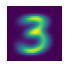

In [20]:
# Avg 3 img - ideal 3 for the current dataset
mean_3 = threes.mean(0)
show_image(mean_3);

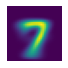

In [21]:
# Avg 7
mean_7 = sevens.mean(0)
show_image(mean_7);

Research shows that recall and understanding improve dramatically when you are engaged with the learning process by solving problems, experimenting, and trying new ideas yourself.

Let’s now pick an arbitrary 3 and measure its distance from our “ideal digits.” Now we have to decide how to measure the distances between digits

**Ideas**
1. Take avg for ideal images and the one that we want to classify. Substract the values and assign that class for which we have the min value
2. Use L1/L2 metrics (MAE/RMSE)

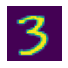

In [22]:
# Take an img 
img_3 = threes[1]
show_image(img_3);

In [23]:
def measure_distances(sel_img, ideal_3, ideal_7):
    dist_3_mae = (sel_img - ideal_3).abs().mean()
    dist_3_rmse = ((sel_img - ideal_3)**2).mean().sqrt()
    
    dist_7_mae = (sel_img - ideal_7).abs().mean()
    dist_7_rmse = ((sel_img - ideal_7)**2).mean().sqrt()
    return [dist_3_mae, dist_3_rmse], [dist_7_mae, dist_7_rmse]

In [24]:
measure_distances(
    sel_img=img_3,
    ideal_3=mean_3,
    ideal_7=mean_7
)

([tensor(0.1114), tensor(0.2021)], [tensor(0.1586), tensor(0.3021)])

**PyTorch Loss Functions**

PyTorch already provides both of these as loss functions. You’ll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as `F`

In [25]:
# Calculate the same using PyTorch 
F.l1_loss(img_3.float(), mean_3), F.mse_loss(img_3, mean_3).sqrt()

(tensor(0.1114), tensor(0.2021))

### NumPy Arrays and PyTorch Tensors
- `NumPy` and `PyTorch` has similar API, **but PyTorch supports GPU, calculating gradients** - critical for DL
- `NumPy` arrays and `PyTorch` tensors are thousands of times faster than using pure Python.
- `NumPy` and `PyTorch` are wrapper for C
- Arrays must have a single datatype!

### NumPy and PyTorch Main Difference
- NumPy can have `jagged array` - array of arrays where each array can have different shape and its own datatype
- PyTorch cannot have `jagged array` - it is always a regularly shaped multidimensional rectangular structure

In [26]:
data = [
    [1, 2, 3],
    [4, 5, 6]
]

# NumPy Array (using FastAI)
num_arr = array(data)
torch_tensor = tensor(data)

display(num_arr)
display(torch_tensor)

array([[1, 2, 3],
       [4, 5, 6]])

tensor([[1, 2, 3],
        [4, 5, 6]])

In [27]:
# Torch array type
torch_tensor.type()

'torch.LongTensor'

- datatype automatically changes using math operations

In [28]:
torch_tensor*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

### Baseline Testing 
Let's test our baseline solution for validation set

In [30]:
# Download val data
val_3_imgs = torch.stack([
    tensor(Image.open(number)) for number in (path/'valid'/'3').ls()
])

val_7_imgs = torch.stack([
    tensor(Image.open(number)) for number in (path/'valid'/'7').ls()
])

# Change datatype
val_3_imgs = val_3_imgs.float()/255
val_7_imgs = val_7_imgs.float()/255

val_3_imgs.shape, val_7_imgs.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [43]:
# Distance calculation
def compute_distance(x, y, metric='rmse'):
    if metric=='rmse':
        return F.mse_loss(x, y).sqrt()
    else:
        return F.l1_loss(x, y)

In [44]:
# Single example distance 
compute_distance(
    x=img_3,
    y=mean_3,
    metric='rmse'
)

tensor(0.2021)

### Distances between all examples 
- Use loop for val_3_imgs (not fast solution)
- Use PyTorch tensor and get the distances for all examples in this tensor once

PyTorch is not going to complain that shapes not matching instead it will use `broadcasting`

In [49]:
val_3_distances = compute_distance(
    x=val_3_imgs,
    y=mean_3,
    metric='mae'
)

val_3_distances, val_3_distances.shape

c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Using a target size (torch.Size([28, 28])) that is different to the input size (torch.Size([1010, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


(tensor(0.1296), torch.Size([]))

In [50]:
# Function that tells if the number is 3
def is_3(number, metric='rmse'):
    return compute_distance(number, mean_3, metric) < compute_distance(number, mean_7, metric)

In [51]:
# Apply to the val set of 3s
is_3(val_3_imgs, metric='mae')

c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Using a target size (torch.Size([28, 28])) that is different to the input size (torch.Size([1010, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


tensor(True)

Now we can calculate the accuracy for each of the 3s and 7s, by taking the average of that function for all 3s and its inverse for all 7s:

In [52]:
accuracy_3s = is_3(val_3_imgs).float().mean()
accuracy_7s = (1 - is_3(val_7_imgs).float()).mean()

print('Accuracy 3s: ', accuracy_3s)
print('Accuracy 7s: ', accuracy_7s)
print('Avg Model Accuracy: ', (accuracy_3s + accuracy_7s)/2)

Accuracy 3s:  tensor(1.)
Accuracy 7s:  tensor(1.)
Avg Model Accuracy:  tensor(1.)


c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Using a target size (torch.Size([28, 28])) that is different to the input size (torch.Size([1010, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  after removing the cwd from sys.path.
c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Using a target size (torch.Size([28, 28])) that is different to the input size (torch.Size([1028, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  after removing the cwd from sys.path.


This looks like a pretty good start! We’re getting over 90% accuracy on both 3s and 7s, and we’ve seen how to define a metric conveniently using broadcasting. But let’s be honest: **3s and 7s are very different-looking digits.** 

**We’re classifying only 2 out of the 10** possible digits so far. So we’re going to need to do better!

### Stochastic Gradient Descend 
Instead of trying to find the similarity between an image and an “ideal image,” we could instead **look at each individual pixel and come up with a set of weights for each**, such that the highest weights are associated with those pixels most likely to be black for a particular category. 

For instance, pixels toward the bottom right are not very likely to be activated for a 7. This can be represented as a function and set of weight values for each possible category, for instance, the probability of being the number 8:

In [53]:
def proba_eight(x, w): return (x.w).sum()

Searching for the best vector W is a way to search for the best function for recognizing 8s.

### Key Steps for Training All DL Models  
1. Initialize the weights
2. Make prediction for each example/observation
3. Base on these predictions, calculate how good a model is (its loss)
4. Calculate the gradient, which measures for each weight how changing that weightwould change the loss
5. Change all weights based on the gradient 
6. Repeat from step 2 to 5 util you decide to stop the training process (metric is good, other rules)

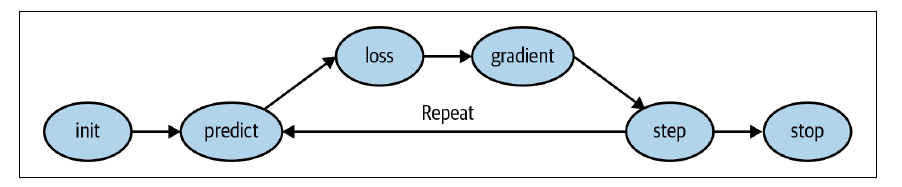

**Initialize**

We initialize the parameters to random values. This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well. 

**Loss**

We need a function that will return a number that is small if the performance of the model is good.

**Step**

Increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, or a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows
us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating gradients.

**Stop**

Once we’ve decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision. For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time

### Simple Loss Example
Let's pretend that our loss - quadratic function 

In [54]:
import matplotlib.pyplot as plt

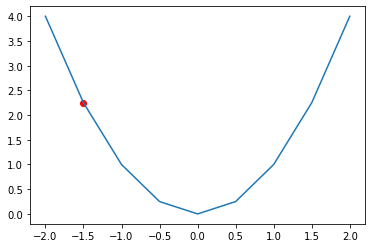

In [55]:
x_range = np.arange(-2, 2.5, 0.5)
def f(x): return x**2

plt.plot(x_range, f(x_range))
plt.scatter(-1.5, f(-1.5), color='red');

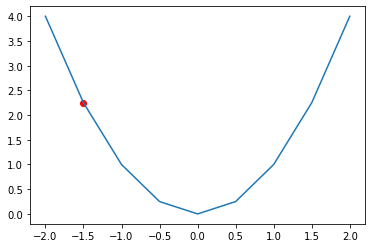

In [56]:
# 1st step: random weight initialization, loss calculation

plt.plot(x_range, f(x_range))
plt.scatter(-1.5, f(-1.5), color='red');

We need to change the weight in the direction of the slope, calculate the loss and adjust the weight again until we are in the function minima.

Isaac Newton, who pointed out that we can optimize arbitrary functions in this way. **Regardless of how complicated our functions become,** this basic approach of gradient descent will not significantly change. The only minor changes we will see later in this book are some **handy ways** we can make it faster, by finding better steps.

### The Gradients 
The gradients will tell us how much we have to change each weight to make our model better. The derivative of a function tells you how much a change in its parameters will change its result (**it calculates the change, rather than the value**)

When we know how our function will change, we know what we need to do to make it smaller

**PyTorch is able to automatically compute the derivative of nearly any function** What’s more, it does it very fast. Most of the time, it will
be at least as fast as any derivative function that you can create by hand. Let’s see an example.

Method `requires_grad` tells that we want to calculate gradients with respect to that variable at that value.

**Important**

In deep learning, “gradient” usually means the value of a function’s derivative at a particular
argument value. The PyTorch API also **puts the focus on the argument, not the function** you’re actually computing the gradients of.

In [58]:
# Repeat the steps but using a vector argument
val = tensor([3.,4.,10.]).requires_grad_()
val

tensor([ 3.,  4., 10.], requires_grad=True)

In [59]:
# Define new function
def f(x): return (x**2).sum()
y = f(val)
y

tensor(125., grad_fn=<SumBackward0>)

In [60]:
# Find the gradients 
y.backward()
val.grad

tensor([ 6.,  8., 20.])

### Stepping with a Learning Rate
Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the learning rate (LR)

- learning rate is often a number between 0.001 and 0.1, but can be any value

The weights are adjusted using: `w -= w.grad * LR`

In [61]:
LR = 0.1
val.grad 

tensor([ 6.,  8., 20.])

### Learning Rate Value
- **Too low:** have to do many steps to converge
- **Too big:** it will jump the optima and diverge; It also may bounce

### SGD Example 
Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this

In [62]:
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

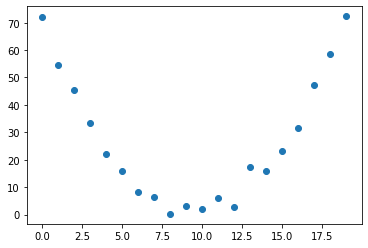

In [63]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1 # bx + ax^2 + c
plt.scatter(time, speed);

We’ve added a bit of random noise. Using SGD, we can try to find a function that matches our observations. We can’t consider every possible function, so let’s use a guess that it will be quadratic (i.e. a function of the form `a*(time**2)+(b*time)+c`)

In [64]:
# Define the assumed function 
def f(t, params):
    a, b, c = params
    return a*(t**2) + (b*t) + c

To find the best quadratic function, we need to find only the best values for a, b, and c (weights/parameters)

1. We need to define what we mean by “best.” We define this precisely by choosin a loss function, which will return a value based on a prediction and a target, where lower values of the function correspond to “better” predictions. For continuous data, it’s common to use `MSE`

In [65]:
# Define Loss function
def mse(preds, targets):
    return ((preds - targets)**2).mean()

**1. Initialize the parameters**

First, we initialize the parameters to random values and tell PyTorch that we want to track their gradients using requires_grad_:

In [66]:
params = torch.randn(3).requires_grad_() #  randomly initialize a, b, c
params

tensor([-0.3835,  1.4807,  0.0244], requires_grad=True)

**2. Calculate the predictions**

In [67]:
preds = f(time, params)
preds

tensor([ 2.4428e-02,  1.1216e+00,  1.4519e+00,  1.0151e+00, -1.8853e-01,
        -2.1591e+00, -4.8967e+00, -8.4012e+00, -1.2673e+01, -1.7711e+01,
        -2.3517e+01, -3.0089e+01, -3.7428e+01, -4.5534e+01, -5.4408e+01,
        -6.4048e+01, -7.4455e+01, -8.5629e+01, -9.7570e+01, -1.1028e+02],
       grad_fn=<AddBackward0>)

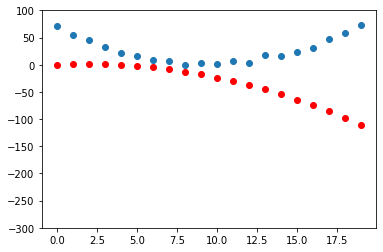

In [68]:
# Let's see how close our predictions are to our targets
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)
    
show_preds(preds)

The predictions are very bad!!!

**3. Calculate the loss**

In [69]:
loss = mse(preds, speed)
loss

tensor(5976.6064, grad_fn=<MeanBackward0>)

Now we need to decrease the loss. To do that, **we’ll need to know the gradients**

**4. Calculate the gradients**


In [70]:
loss.backward()
params.grad

tensor([-24381.9922,  -1537.2554,   -120.4224])

In [71]:
# Multiply the gradients by LR
params.grad * 1e-5

tensor([-0.2438, -0.0154, -0.0012])

**5. Update the Weights**

Now we need to update the parameters based on the gradients we just calculated (use the Gradient Descent Rule)

In [72]:
LR = 1e-5
def update_weights(weights, lr_rate, grad):
    return weights - lr_rate * grad

print('Weights Before Update: ', params.data)
params.data = update_weights(
    params.data,
    lr_rate=LR,
    grad=params.grad
)

print('Weights After Update: ', params.data)

Weights Before Update:  tensor([-0.3835,  1.4807,  0.0244])
Weights After Update:  tensor([-0.1397,  1.4960,  0.0256])


**Important**

After updating the weights, we have new weigths. If we call `params.grad` it will return the old gradients for previos parameters. To get the gradients for new parameters we need to call `params.requires_grad_()` then use `loss.backward()` and only then can get new gradients

In [73]:
# let's see if the loss has improved 
preds = f(time, params)
mse(preds, speed)

tensor(1694.1211, grad_fn=<MeanBackward0>)

**The loss did decreased**

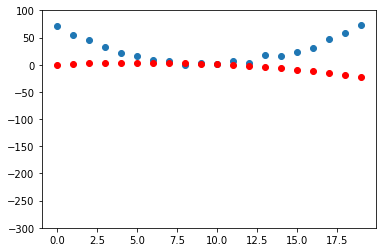

In [74]:
show_preds(preds)

The algorithm is iterative. Let's put all together in a single function

In [75]:
def run_gd(params, lr_rate, n_repeat, show_loss=True):
    for _ in range(n_repeat):
        preds = f(time, params)
        loss = mse(preds, target)
        loss.backward() # tell that we need the gradients for this function
        params.data = update_weights( # get new weights 
            weights=params.data,
            grad=params.grad,
            lr_rate=lr_rate
        )
        params.grad = None
        if show_loss:
            print(loss.item())
    return preds

In [76]:
target = speed
time = torch.arange(0, 20).float()
lr_rate = 1e-5

# Params initialization
params = torch.randn(3).requires_grad_()

# Optimize the function 
run_gd(params, lr_rate, n_repeat=10)

58152.60546875
11564.5888671875
2748.70703125
1080.4671630859375
764.7786865234375
705.0343627929688
693.7222900390625
691.5753173828125
691.16259765625
691.0779418945312


tensor([-0.5820, -1.6147, -2.1888, -2.3042, -1.9611, -1.1594,  0.1010,  1.8199,
         3.9974,  6.6335,  9.7282, 13.2815, 17.2934, 21.7639, 26.6929, 32.0806,
        37.9269, 44.2317, 50.9952, 58.2172], grad_fn=<AddBackward0>)